在了解了线性回归的背景知识之后，现在我们可以动手实现它了。

尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。

因此，本节将介绍如何只利用Tensor和GradientTape来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import random

2.5.0


## 3.2.1 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。

设训练数据集样本数为1000，输入个数（特征数）为2。

给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签 $$ \boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon $$

其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。

下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000

true_w = [2,-3.4]
true_b = 4.2

features = tf.random.normal((num_examples,num_inputs),stddev=1)

labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels.shape

TensorShape([1000])

In [3]:
labels += tf.random.normal(labels.shape, stddev=0.01)

In [4]:
labels.shape

TensorShape([1000])

注意，features 的每一行是一个长度为 2 的向量，而 labels 的每一行是一个长度为 1 的向量（标量）。

In [5]:
print(features[0],labels[0])

tf.Tensor([ 0.0651636  -0.08652201], shape=(2,), dtype=float32) tf.Tensor(4.6187706, shape=(), dtype=float32)


通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

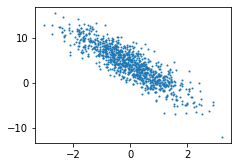

In [6]:
def set_figsize(figsize=(3.5,2.5)):
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:,1],labels,1)

## 3.2.2 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。

这里我们定义一个函数：它每次返回 batch_size（批量大小）个随机样本的特征和标签。

In [7]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    idxs = list(range(num_examples))
    random.shuffle(idxs)
    
    for i in range(0, num_examples, batch_size):
        j = idxs[i : min(i + batch_size, num_examples)]
        yield tf.gather(features,axis=0,indices=j),tf.gather(labels,axis=0,indices=j)

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [8]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X,y)
    break

tf.Tensor(
[[-0.17205659 -0.9768843 ]
 [ 0.52273226  0.638269  ]
 [ 0.70116854 -0.4922135 ]
 [-1.4858334  -0.8460434 ]
 [ 0.05539612  0.3443882 ]
 [-0.7713595  -0.5591494 ]
 [-1.1851933  -1.5614344 ]
 [ 0.31416166  0.05419862]
 [ 0.627155   -1.6464456 ]
 [-0.28019595  0.8177773 ]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 7.178976   3.074776   7.2804446  4.113937   3.1460993  4.5595665
  7.1316833  4.6354213 11.056623   0.8579834], shape=(10,), dtype=float32)


## 3.2.3 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [9]:
w = tf.Variable(tf.random.normal((num_inputs, 1), stddev=0.01))
b = tf.Variable(tf.zeros((1,)))

## 3.2.4 定义模型

In [10]:
def linreg(X, w, b):
    return tf.matmul(X,w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值 y 变形成预测值 y_hat 的形状。以下函数返回的结果也将和 y_hat 的形状相同。

In [11]:
def squared_loss(y_hat,y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

以下的 sgd 函数实现了上一节中介绍的小批量随机梯度下降算法。

它通过不断迭代模型参数来优化损失函数。

这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。

我们将它除以批量大小来得到平均值。

In [12]:
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。

在每次迭代中，我们根据当前读取的小批量数据样本(特征 X 和标签 y)，通过调用反向函数 t.gradients 计算小批量随机梯度，并调用优化算法 sgd 迭代模型参数。

由于我们之前设批量大小 batch_size 为 10 ，每个小批量的损失 l 的形状为 (10, 1)。

回忆一下自动求梯度一节。由于变量 l 并不是一个标量，所以我们可以调用 reduce_sum() 将其求和得到一个标量，再运行 t.gradients得到该变量有关模型参数的梯度。

注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。

这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。

在实践中，大多超参数都需要通过反复试错来不断调节。

虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。

而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [14]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        with tf.GradientTape() as t:
            t.watch([w,b])
            l = tf.reduce_sum(loss(net(X, w, b),y))
        grads = t.gradient(l, [w,b])
        sgd([w,b], lr, batch_size, grads)
    train_l = loss(net(features,w,b), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l)))

epoch 1, loss 0.030995
epoch 2, loss 0.000106
epoch 3, loss 0.000048


输出： epoch 1, loss 0.028907 epoch 2, loss 0.000101 epoch 3, loss 0.000049

训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [15]:
true_w

[2, -3.4]

In [16]:
w

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9995718],
       [-3.3998516]], dtype=float32)>

In [17]:
true_b

4.2

In [18]:
b

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.1993127], dtype=float32)>